In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 데이터셋 폴더 나누기

In [2]:
import os
import random
import shutil

def dataset_train_val_test(dataset_path):
    for input_path, output_path in dataset_path.items():

        train_ratio = 0.7
        val_ratio = 0.15
        test_ratio = 0.15

        # 폴더가 존재하지 않으면 생성
        os.makedirs(output_path, exist_ok=True)

        # 폴더 내 파일 목록 가져오기
        file_list = os.listdir(input_path)
        file_count = len(file_list)

        # 파일 목록을 무작위로 섞음
        random.shuffle(file_list)

        # 각 데이터의 인덱스 범위 계산
        train_end = int(file_count * train_ratio)
        val_end = train_end + int(file_count * val_ratio)

        # 데이터 복사 및 분할
        for i, file_name in enumerate(file_list):
            src_path = os.path.join(folder_path, file_name)

            if i < train_end:
                dst_folder = "train/"+input_path
            elif i < val_end:
                dst_folder = "val/"+input_path
            else:
                dst_folder = "test/"+input_path

            dst_path = os.path.join(output_path, dst_folder, file_name)
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)
            shutil.copy(src_path, dst_path)

In [3]:
# dataset_path = {
#     "Dog/" : "GD_data_1/",
#     "Cat/" : "GD_data_1/"
# }

# dataset_train_val_test(dataset_path)

## 데이터셋 전처리

In [17]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

IMAGE_SIZE = 224
BATCH = 32

train_ds = image_dataset_from_directory(
    directory="GD_data_1/train",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH,
    label_mode='binary'
)
val_ds = image_dataset_from_directory(
    directory="GD_data_1/val",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH,
    label_mode='binary'
)
test_ds = image_dataset_from_directory(
    directory="GD_data_1/test",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH,
    label_mode='binary'
)

Found 17500 files belonging to 2 classes.
Found 3750 files belonging to 2 classes.
Found 3750 files belonging to 2 classes.


## data agumentation 블록 만들기

In [5]:
from keras import layers

data_augmentation = keras.Sequential(
    [
#       layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

## ResNet 모델 구성

In [6]:
def build_resnet_block(input_x, num_cnn=3, channel=64, block_num=1,is_50 = False,is_plain = False):
    # 입력 레이어
    x = input_x
    cnn_num = 0  # Added initialization for cnn_num
    if not is_50:
    # CNN 레이어
        for cnn_num in range(num_cnn):
            identity = x
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
            )(x)
            if not is_plain:
                identity_channel = identity.shape.as_list()[-1]    

                if identity_channel != channel:
                    identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
                # skip connection
                x = keras.layers.Add()([x,identity])   
            else:
                pass
    else :
        for cnn_num in range(num_cnn):
            identity = x
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(1,1),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
            )(x)
            x = keras.layers.Conv2D(
                filters=channel * 4,
                kernel_size=(1,1),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_2_conv{cnn_num}'
            )(x)
            if not is_plain:
                identity_channel = identity.shape.as_list()[-1]    

                if identity_channel != channel * 4:  # Modified condition to update identity_channel
                    identity = keras.layers.Conv2D(channel * 4, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
                # skip connection
                x = keras.layers.Add()([x,identity])   
            else:
                pass
    #     Max Pooling 레이어
    # 마지막 블록 뒤에는 pooling을 하지 않음
    if identity.shape[1] != 1:        
        x = keras.layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=2,
            name=f'block{block_num}_pooling'
        )(x)

    return x

In [19]:
def build_resnet(input_shape,
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10,is_50 = False, is_plain = False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    if is_50:
        num_cnn_list = [3,4,6,3]
        channel_list = [64,128,256,512]
        num_classes = 10
        
    input_layer = keras.Input(shape=input_shape)  # input layer를 만들어둡니다.
#     output = data_augmentation(output)
    #conv1층
    output = layers.Conv2D(filters=64,
                       kernel_size = (7,7),
                       strides = 2,
                         padding = 'same')(input_layer)
    output = layers.BatchNormalization()(output)
    
    #conv2_x pooling
    output = layers.MaxPooling2D(pool_size = (2,2), strides = 2,)(output)    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i,
            is_50 = is_50,
            is_plain = is_plain
        )    
    output = layers.AveragePooling2D(padding = 'same')(output)
    output = layers.Flatten(name='flatten')(output)
    output = layers.Dense(512, activation='relu', name='fc1')(output)    
    output = layers.Dense(1, activation='sigmoid', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [20]:
ResNet_34 = build_resnet((IMAGE_SIZE, IMAGE_SIZE, 3), is_50=False, is_plain=False)
ResNet_50 = build_resnet((IMAGE_SIZE, IMAGE_SIZE, 3), is_50=True, is_plain=False)

In [9]:
Plain_34 = build_resnet((IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=2, is_50=False, is_plain=True)
Plain_50 = build_resnet((IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=2, is_50=True, is_plain=True)

In [10]:
ResNet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [11]:
ResNet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 112, 112, 64) 256         conv2d_4[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 56, 56, 64)   0           batch_normalization_17[0][0]     
____________________________________________________________________________________________

In [12]:
print(train_ds)

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>


<TakeDataset shapes: ((None, 224, 224, 3), (None, 1)), types: (tf.float32, tf.float32)>


NameError: name 'class_names' is not defined

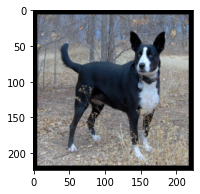

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
print(train_ds.take(1))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
    pass

In [21]:
ResNet_34.compile(
    loss='binary_crossentropy',
    optimizer= "adam",
    metrics=['accuracy'])

history_ResNet_34 = ResNet_34.fit(
    train_ds,
    epochs=1,
    validation_data=val_ds,
    verbose=1)

137/547 [======>.......................] - ETA: 1:10 - loss: 2.3804 - accuracy: 0.4854

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


154/547 [=======>......................] - ETA: 1:07 - loss: 2.2012 - accuracy: 0.4872

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


202/547 [==========>...................] - ETA: 58s - loss: 1.8631 - accuracy: 0.4915

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


206/547 [==========>...................] - ETA: 57s - loss: 1.8412 - accuracy: 0.4917

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  Input size should match (header_size + row_size * abs_height) but they differ by 2
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
  (1) Invalid argument:  Input size should match (header_size + row_size * abs_height) but they differ by 2
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
	 [[gradient_tape/binary_crossentropy/logistic_loss/mul/Shape_1/_8]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_19042]

Function call stack:
train_function -> train_function


In [ ]:
Plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer= keras.optimizers.Adam(),
    metrics=['accuracy'])

history_Plain_34 = Plain_34.fit(
    train_ds,
    epochs=15,
    validation_data=val_ds,
    verbose=1,
    use_multiprocessing=True)